# Domain Generalization (ERM) on PACS

In [7]:
import os
import random
from pathlib import Path
from tqdm import tqdm

import torch
from torch import nn
from torch.utils.data import DataLoader, ConcatDataset, Subset
from torchvision import transforms, datasets

 
DATA_ROOT = Path(r"C:\Users\Fatim_Sproj\Desktop\Fatim\Spring 2025\Datasets\pacs_data\pacs_data") 
SOURCE_DOMAINS = ["art_painting", "cartoon", "photo"]
TARGET_DOMAIN = "sketch"

IMAGE_SIZE = 224
BATCH_SIZE = 64
NUM_EPOCHS = 10
LR = 1e-5
SEED = 42

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

VIT_MODEL_NAME = "WinKawaks/vit-tiny-patch16-224"

random.seed(SEED)
torch.manual_seed(SEED)


In [8]:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])


def load_domain(domain_name, transform):
    p = DATA_ROOT / domain_name
    if not p.exists():
        raise FileNotFoundError(f"Domain path not found: {p.resolve()}")
    ds = datasets.ImageFolder(str(p), transform=transform)
    return ds

source_datasets = {d: load_domain(d, train_transform) for d in SOURCE_DOMAINS}
target_dataset = load_domain(TARGET_DOMAIN, val_transform)

class_lists = [tuple(ds.classes) for ds in source_datasets.values()] + [tuple(target_dataset.classes)]
if len(set(class_lists)) != 1:
    print("WARNING: Class lists differ between domains. Ensure class folders match and are ordered the same.")

NUM_CLASSES = len(next(iter(source_datasets.values())).classes)

train_dataset = ConcatDataset(list(source_datasets.values()))
val_fraction = 0.2
num_val = int(len(train_dataset) * val_fraction)
num_train = len(train_dataset) - num_val
train_subset = Subset(train_dataset, list(range(0, num_train)))
val_subset = Subset(train_dataset, list(range(num_train, num_train + num_val)))

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

target_loader = DataLoader(target_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

source_loaders = {d: DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
                  for d, ds in source_datasets.items()}

print(f"Train size: {len(train_subset)}, Val size: {len(val_subset)}, Target size: {len(target_dataset)}")
print(f"Num classes: {NUM_CLASSES}")


Train size: 4842, Val size: 1210, Target size: 3929
Num classes: 7


In [9]:
import torchvision

class DomainBedModel(nn.Module):
    def __init__(self, featurizer, classifier, dropout_rate=0.0):
        super().__init__()
        self.featurizer = featurizer
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = classifier

    def forward(self, x):
        features = self.featurizer(x)
        features_dropped_out = self.dropout(features)
        return self.fc(features_dropped_out)

resnet_dropout = 0.0
freeze_bn_flag = True

base_model = torchvision.models.resnet18(pretrained=True)
n_outputs = base_model.fc.in_features
base_model.fc = nn.Identity()
featurizer = base_model

if freeze_bn_flag:
    for module in featurizer.modules():
        if isinstance(module, nn.BatchNorm2d):
            module.eval()

classifier = nn.Linear(n_outputs, NUM_CLASSES)

model = DomainBedModel(
    featurizer,
    classifier,
    dropout_rate=resnet_dropout
).to(DEVICE)

criterion = nn.CrossEntropyLoss()

c:\Users\Fatim_Sproj\anaconda3\envs\bacp\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Fatim_Sproj\anaconda3\envs\bacp\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()


def train_one_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(loader, desc="Train", leave=False)
    for imgs, labels in pbar:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += imgs.size(0)
        pbar.set_postfix({'loss': total_loss/total, 'acc': 100*correct/total})
    return total_loss/total, 100*correct/total

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0
    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        total_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += imgs.size(0)
    return total_loss/total, 100*correct/total


In [5]:

import matplotlib.pyplot as plt
from pathlib import Path

best_target_acc = 0.0
OUTPUT_DIR = Path('./erm_outputs')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

history = []

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"Epoch {epoch}/{NUM_EPOCHS}")
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, DEVICE)
    target_loss, target_acc = evaluate(model, target_loader, DEVICE)

    print(f"Train loss: {train_loss:.4f} acc: {train_acc:.2f}%")
    print(f"Target loss: {target_loss:.4f} acc: {target_acc:.2f}%")

    history.append({
        "epoch": epoch,
        "train_loss": train_loss,
        "train_acc": train_acc,
        "target_loss": target_loss,
        "target_acc": target_acc
    })

    if target_acc > best_target_acc:
        best_target_acc = target_acc
        torch.save(model.state_dict(), OUTPUT_DIR / 'best_model.pth')
        print(f"Saved best model (Target acc: {target_acc:.2f}%)")

print(f"\nBest target-domain accuracy: {best_target_acc:.2f}%")

# ---- PLOTTING ----
epochs = [h["epoch"] for h in history]
train_accs = [h["train_acc"] for h in history]
target_accs = [h["target_acc"] for h in history]
train_losses = [h["train_loss"] for h in history]
target_losses = [h["target_loss"] for h in history]

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accs, label="Train Acc")
plt.plot(epochs, target_accs, label="Target Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("ERM Training vs Target Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "accuracy_plot.png")
plt.close()

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, target_losses, label="Target Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ERM Training vs Target Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "loss_plot.png")
plt.close()

Epoch 1/10


Train loss: 1.5095 acc: 48.99%
Target loss: 1.6088 acc: 39.07%
Saved best model (Target acc: 39.07%)
Epoch 2/10


Train loss: 0.7511 acc: 83.75%
Target loss: 1.3627 acc: 58.03%
Saved best model (Target acc: 58.03%)
Epoch 3/10


Train loss: 0.4600 acc: 90.27%
Target loss: 1.2348 acc: 61.36%
Saved best model (Target acc: 61.36%)
Epoch 4/10


Train loss: 0.3229 acc: 93.35%
Target loss: 1.1623 acc: 62.31%
Saved best model (Target acc: 62.31%)
Epoch 5/10


Train loss: 0.2393 acc: 95.29%
Target loss: 1.1023 acc: 62.23%
Epoch 6/10


Train loss: 0.1856 acc: 96.51%
Target loss: 1.0660 acc: 63.86%
Saved best model (Target acc: 63.86%)
Epoch 7/10


Train loss: 0.1419 acc: 97.69%
Target loss: 1.0436 acc: 63.20%
Epoch 8/10


Train loss: 0.1072 acc: 98.62%
Target loss: 1.0785 acc: 61.82%
Epoch 9/10


Train loss: 0.0861 acc: 99.01%
Target loss: 1.0546 acc: 62.48%
Epoch 10/10


Train loss: 0.0672 acc: 99.57%
Target loss: 1.0789 acc: 62.28%

Best target-domain accuracy: 63.86%


In [6]:
best_model_path = OUTPUT_DIR / 'best_model.pth'

model = DomainBedModel(
    featurizer,
    classifier,
    dropout_rate=resnet_dropout
).to(DEVICE)

state_dict = torch.load(best_model_path, map_location=DEVICE)
model.load_state_dict(state_dict)
model.eval()

domain_results = {}
total_acc = 0.0

# Evaluate on all source domains
for d, loader in source_loaders.items():
    loss, acc = evaluate(model, loader, DEVICE)
    domain_results[d] = {"loss": loss, "acc": acc}
    total_acc += acc
    print(f"Source {d}: loss {loss:.4f}, acc {acc:.2f}%")

# Evaluate on target domain
t_loss, t_acc = evaluate(model, target_loader, DEVICE)
domain_results[TARGET_DOMAIN] = {"loss": t_loss, "acc": t_acc}
total_acc += t_acc

# Compute mean accuracies
mean_source_acc = (total_acc - t_acc) / len(source_loaders)
mean_acc = total_acc / (len(source_loaders) + 1)

print(f"\nMean source accuracy: {mean_source_acc:.2f}%")
print(f"Mean domain accuracy (incl. target): {mean_acc:.2f}%")

final_results = {
    "best_target_acc": best_target_acc,
    "mean_source_acc": mean_source_acc,
    "domain_results": domain_results,
    "mean_acc": mean_acc
}

# Save model and results
torch.save(model, OUTPUT_DIR / 'final_model_full.pth')
print(f"Saved final model to {OUTPUT_DIR}/")

# --- Bar Plot ---
domains = list(domain_results.keys())
accuracies = [domain_results[d]["acc"] for d in domains]

plt.figure(figsize=(8, 5))
bars = plt.bar(domains, accuracies, color='skyblue', edgecolor='black', linewidth=1.2)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.title("Per-Domain Accuracy (ERM Final Model)", fontsize=13, pad=10)

plt.xticks(range(len(domains)), domains, rotation=0, ha='center', fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig(OUTPUT_DIR / "domain_accuracy_bar.png", dpi=300, bbox_inches='tight')
plt.close()


C:\Users\Fatim_Sproj\AppData\Local\Temp\ipykernel_7372\325786278.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(best_model_path, map_location=DE

Source art_painting: loss 0.1352, acc 98.33%
Source cartoon: loss 0.1344, acc 98.08%
Source photo: loss 0.2314, acc 92.46%

Mean source accuracy: 96.29%
Mean domain accuracy (incl. target): 88.18%
Saved final model to erm_outputs/


C:\Users\Fatim_Sproj\AppData\Local\Temp\ipykernel_7372\353648319.py:63: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  erm_model.load_state_dict(torch.load(PATH_TO_ERM_MODEL,

ERM and SAM models loaded successfully.

Calculating loss surface for ERM model...


Calculating Loss Surface for DomainBedModel: 100%|██████████| 41/41 [06:11<00:00,  9.05s/it]



Calculating loss surface for SAM model...


Calculating Loss Surface for DomainBedModel: 100%|██████████| 41/41 [06:07<00:00,  8.97s/it]


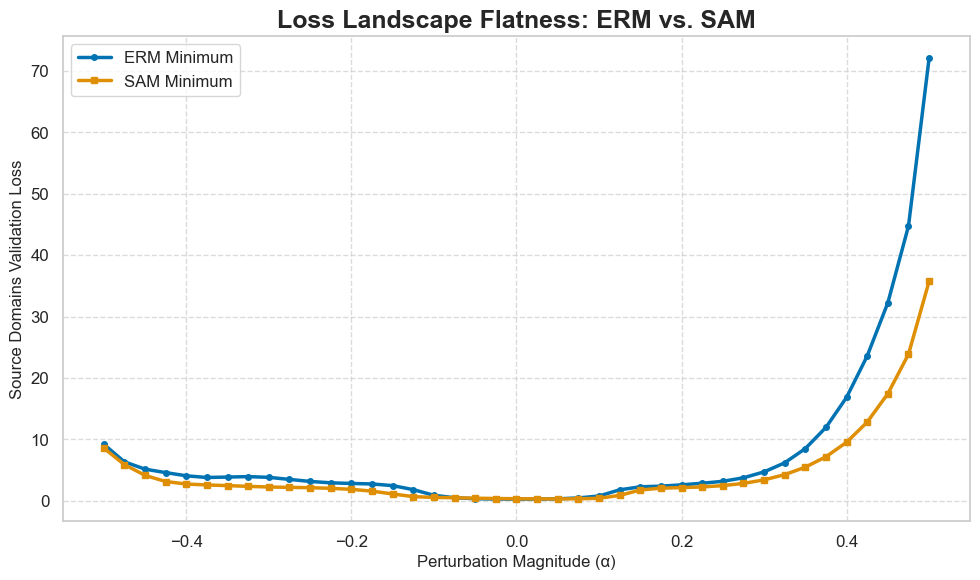

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import copy
from tqdm import tqdm

sns.set_theme(style="whitegrid", palette="colorblind", font_scale=1.1)

PATH_TO_ERM_MODEL = Path(r"C:\Users\Fatim_Sproj\Desktop\Haseeb\ATML\PA2\erm_outputs\best_model.pth")
PATH_TO_SAM_MODEL = Path(r"C:\Users\Fatim_Sproj\Desktop\Haseeb\ATML\PA2\sam_outputs\best_model.pth")

def create_new_model():
    base_model = torchvision.models.resnet18(weights=None)
    n_outputs = base_model.fc.in_features
    base_model.fc = nn.Identity()
    featurizer = base_model

    if freeze_bn_flag:
        for module in featurizer.modules():
            if isinstance(module, nn.BatchNorm2d):
                module.eval()

    classifier = nn.Linear(n_outputs, NUM_CLASSES)
    
    return DomainBedModel(
        featurizer,
        classifier,
        dropout_rate=resnet_dropout
    ).to(DEVICE)

def get_loss_surface_1d(model, dataloader, direction, alphas, device):
    initial_state_dict = copy.deepcopy(model.state_dict())
    losses = []
    
    param_keys = [k for k, v in model.named_parameters() if v.requires_grad]

    for alpha in tqdm(alphas, desc=f"Calculating Loss Surface for {model.__class__.__name__}"):
        perturbed_state_dict = copy.deepcopy(initial_state_dict)
        for i, key in enumerate(param_keys):
            perturbed_state_dict[key] += alpha * direction[i]
        
        model.load_state_dict(perturbed_state_dict)
        
        loss, _ = evaluate(model, dataloader, device)
        losses.append(loss)
        
    model.load_state_dict(initial_state_dict)
    return losses

if __name__ == "__main__":
    if not PATH_TO_ERM_MODEL.exists() or not PATH_TO_SAM_MODEL.exists():
        print(f"ERROR: Model weight files not found at {PATH_TO_ERM_MODEL.resolve()} and/or {PATH_TO_SAM_MODEL.resolve()}.")
        print("Please ensure your trained ERM and SAM model weights are saved to these paths.")
        print("You can create dummy files to run this script for testing purposes:")
    else:
        erm_model = create_new_model()
        sam_model = create_new_model()
        
        erm_model.load_state_dict(torch.load(PATH_TO_ERM_MODEL, map_location=DEVICE))
        sam_model.load_state_dict(torch.load(PATH_TO_SAM_MODEL, map_location=DEVICE))
        print("ERM and SAM models loaded successfully.")

        dataloader = val_loader
        
        torch.manual_seed(SEED)
        direction = [torch.randn_like(p) for p in erm_model.parameters() if p.requires_grad]
        
        param_norms = [p.norm() for p in erm_model.parameters() if p.requires_grad]
        direction_norms = [d.norm() + 1e-8 for d in direction]
        
        for i, d in enumerate(direction):
            direction[i].mul_(param_norms[i] / direction_norms[i])
        
        alphas = np.linspace(-0.5, 0.5, 41)

        print("\nCalculating loss surface for ERM model...")
        erm_losses = get_loss_surface_1d(erm_model, dataloader, direction, alphas, DEVICE)
        
        print("\nCalculating loss surface for SAM model...")
        sam_losses = get_loss_surface_1d(sam_model, dataloader, direction, alphas, DEVICE)

        plt.figure(figsize=(10, 6))
        plt.plot(alphas, erm_losses, label="ERM Minimum", marker='o', markersize=4, linewidth=2.5)
        plt.plot(alphas, sam_losses, label="SAM Minimum", marker='s', markersize=4, linewidth=2.5)

        plt.title("Loss Landscape Flatness: ERM vs. SAM", fontsize=18, weight='bold')
        plt.xlabel("Perturbation Magnitude (α)", fontsize=12)
        plt.ylabel("Source Domains Validation Loss", fontsize=12)
        plt.legend(fontsize=12)
        plt.grid(True, linestyle="--", alpha=0.7)
        plt.tight_layout()
        plt.show()

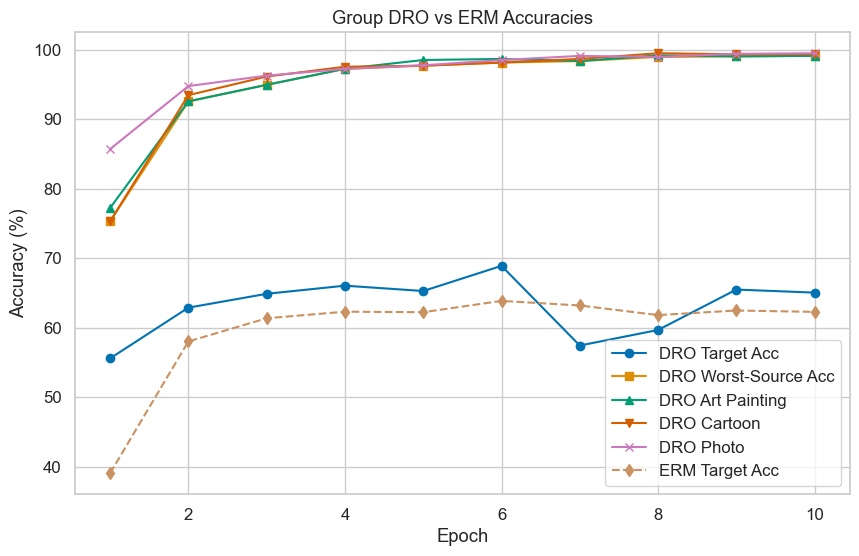

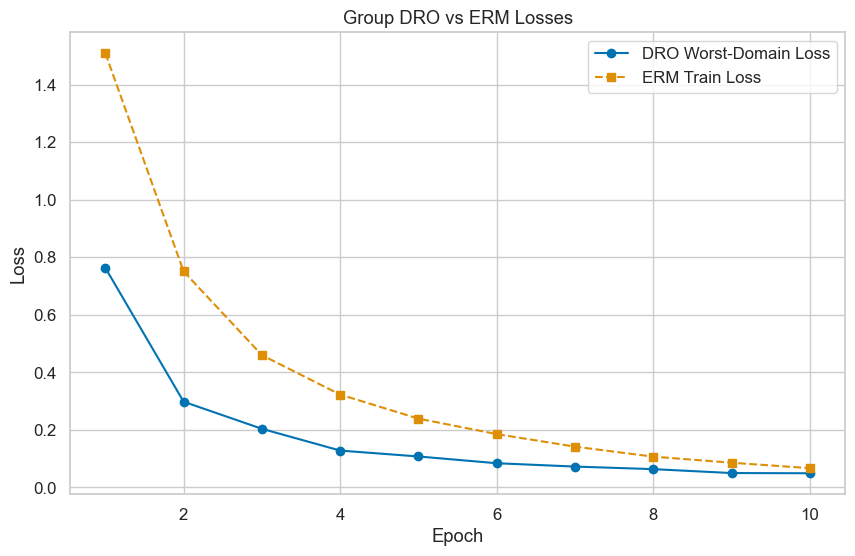

In [13]:
import matplotlib.pyplot as plt

epochs = list(range(1, 11))

# Group DRO
dro_target_acc = [55.59, 62.89, 64.88, 66.05, 65.28, 68.90, 57.44, 59.68, 65.49, 65.05]
dro_worst_acc = [75.30, 92.56, 94.94, 97.23, 97.69, 98.14, 98.36, 98.95, 99.03, 99.11]
dro_art = [77.23, 92.56, 94.94, 97.25, 98.51, 98.66, 98.36, 99.18, 99.03, 99.11]
dro_cartoon = [75.30, 93.45, 96.13, 97.54, 97.69, 98.14, 98.66, 99.48, 99.33, 99.33]
dro_photo = [85.70, 94.76, 96.26, 97.23, 97.75, 98.50, 99.10, 98.95, 99.40, 99.48]
dro_loss = [0.7635, 0.2981, 0.2040, 0.1283, 0.1078, 0.0843, 0.0727, 0.0638, 0.0502, 0.0495]

# ERM
erm_target_acc = [39.07, 58.03, 61.36, 62.31, 62.23, 63.86, 63.20, 61.82, 62.48, 62.28]
erm_train_loss = [1.5095, 0.7511, 0.4600, 0.3229, 0.2393, 0.1856, 0.1419, 0.1072, 0.0861, 0.0672]

# --- Accuracy Plot ---
plt.figure(figsize=(10,6))
plt.plot(epochs, dro_target_acc, 'o-', label='DRO Target Acc')
plt.plot(epochs, dro_worst_acc, 's-', label='DRO Worst-Source Acc')
plt.plot(epochs, dro_art, '^-', label='DRO Art Painting')
plt.plot(epochs, dro_cartoon, 'v-', label='DRO Cartoon')
plt.plot(epochs, dro_photo, 'x-', label='DRO Photo')
plt.plot(epochs, erm_target_acc, 'd--', label='ERM Target Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Group DRO vs ERM Accuracies')
plt.legend()
plt.grid(True)
plt.show()

# --- Loss Plot ---
plt.figure(figsize=(10,6))
plt.plot(epochs, dro_loss, 'o-', label='DRO Worst-Domain Loss')
plt.plot(epochs, erm_train_loss, 's--', label='ERM Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Group DRO vs ERM Losses')
plt.legend()
plt.grid(True)
plt.show()
